### 画像をn枚のパッチに分割しノード特徴を対応する画像パッチとする。画像はカラー画像とする。エッジは最近傍ノードにエッジを張る
一応エッジにはパッチ間のコサイン類似度を代入する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx

In [2]:
from torchvision.datasets import STL10
from torchvision import transforms

target_size=(224,224)
transform=transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

STL10_train = STL10("STL10", split='train', download=True, transform=transform)
 
STL10_test = STL10("STL10", split='test', download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def get_nearest_neighbors(image, row, col): #最近傍ノード番号の取得
    # 画像の形状を取得
    height, width = image.shape[:2]

    # 注目画素の周囲8画素の座標を計算
    neighbors_coords = [(row-1, col-1), (row-1, col), (row-1, col+1),
                        (row, col-1), (row, col+1),
                        (row+1, col-1), (row+1, col), (row+1, col+1)]

    # 注目画素の最近傍画素の値を抜き出す
    nearest_neighbors = []
    for r, c in neighbors_coords:
        # 座標が画像範囲内かチェック
        if 0 <= r < height and 0 <= c < width:
            pixel_value = image[r, c]
            nearest_neighbors.append(pixel_value)
        else:
            # 画像範囲外の場合は0を追加するなど適切な処理を行う
            #nearest_neighbors.append(0)
            pass

    return nearest_neighbors

In [4]:
def make_graph(side_length): #パッチ数分のグラフを作成
    g=dgl.DGLGraph()
    g.add_nodes(side_length**2)
    square_list = np.arange(side_length**2).reshape((side_length, side_length))
    #ノード番号に対応したインデックスを取得
    inds=np.ndindex(square_list.shape)
    inds=[idx for idx in inds]
    #各ノードと最近傍ノード間にエッジを張る
    for i in range(side_length**2):
        x,y=inds[i]
        flatt_nh=get_nearest_neighbors(square_list,x,y)
        for j in flatt_nh:
            if i == j:
                continue
            else:
                g.add_edges(j,i)
    return g

In [5]:
def image_patch(image,num_patch):
    #画像サイズ
    size=image.shape[1]
    #1パッチ当たりの画素数
    patch_width=int(size/num_patch)
    #パッチ保存用配列
    data=[]

    for i in range(0,size,patch_width):
        for j in range(0,size,patch_width):
            data.append(image[:, i : i + patch_width, j : j + patch_width])
    
    return torch.stack(data,dim=0)

In [6]:
#パッチ数
num_patch=8

#トレーニングデータセット
graphs=[]
labels=[]
test_mode=False
test_mumber=100

for image,label in tqdm(STL10_train):
    if test_mode == True:
        if test_mumber < 0:
            break
        else:
            test_mumber -= 1
    #画像をパッチに分割
    n_feat=image_patch(image,num_patch)
    #グラフ作成
    g=make_graph(num_patch)
    #グラフにノード特徴 'f' としてパッチ画像を入力
    g.ndata['f']=n_feat

    #graphsにグラフ labelsにラベルを代入
    graphs.append(g)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/ndata_8patch.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)



  0%|          | 0/5000 [00:00<?, ?it/s]/home/echigo/anaconda3/envs/DGL3/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
100%|██████████| 5000/5000 [06:40<00:00, 12.49it/s]


In [7]:

#テストデータセット
graphs=[]
labels=[]
test_mode=False
test_mumber=100

for image,label in tqdm(STL10_test):
    if test_mode == True:
        if test_mumber < 0:
            break
        else:
            test_mumber -= 1
    #画像をパッチに分割
    n_feat=image_patch(image,num_patch)
    #グラフ作成
    g=make_graph(num_patch)
    #グラフにノード特徴 'f' としてパッチ画像を入力
    g.ndata['f']=n_feat

    #graphsにグラフ labelsにラベルを代入
    graphs.append(g)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/test/ndata_8patch.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)

print('end')

100%|██████████| 8000/8000 [10:54<00:00, 12.23it/s]


end


224
28


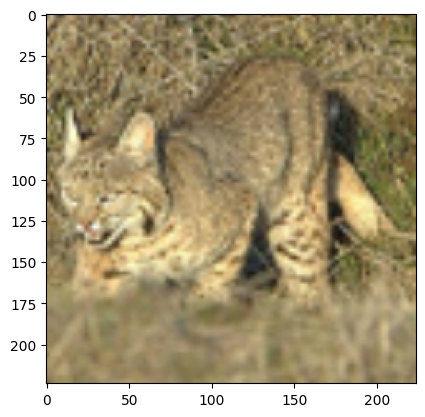

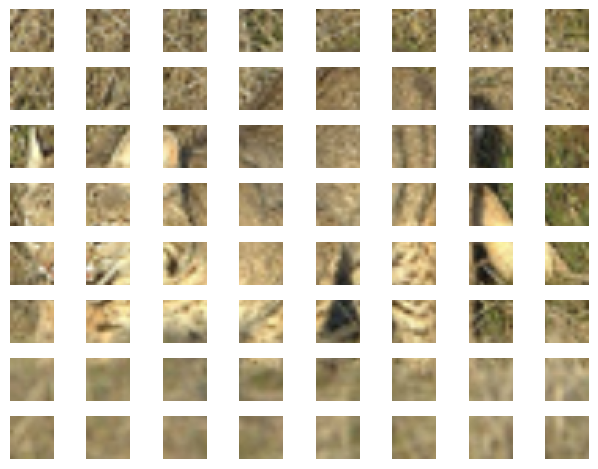

patch num: 8  patch pic size: 28  class: 3


In [19]:
#画像一枚読み込み
image,label=STL10_train[4]
#HWCに入れ替え
image=image.permute(1,2,0)
#表示
plt.imshow(image)
#パッチに分割
#画像をn分割。
num_patch=8
size=image.shape[0]
print(size)
patch_width=int(size/num_patch)
print(patch_width)
data=[]

for i in range(0,size,patch_width):
    #print(i)
    for j in range(0,size,patch_width):
        #print(j)
        data.append(image[i: i + patch_width,j: j + patch_width, :])

#分割した各パッチを正方形に表示
# 1枚の図を作成
fig = plt.figure()

# 画像を追加
for i in range(num_patch**2):
    ax = fig.add_subplot(num_patch, num_patch, i+1)
    ax.imshow(data[i])
    ax.axis('off')

# 画像を表示
plt.tight_layout()
plt.show()
print(f'patch num: {num_patch}  patch pic size: {patch_width}  class: {label}')